# SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [3]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [27]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t):
    a = np.random.normal(0, sigma_a_2 ** 0.5, N)
    v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    print(v)
    x = np.ones(N) * x_0 + (v_1 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

# Part 1

In [28]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        print("P")
        print(P[i])
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        print('tmp1 ')
        print(tmp1)
        print('tmp2 ')
        print(tmp2)
        print('K')
        print(K[i])
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(len(H)) - K[i].dot(H)).dot(P[i])
    return X,K
        

### Parameters

In [29]:
N = 300
sigma_a = 0.2
sigma_n = 20
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

In [30]:
x, z = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)

[ 1.          1.0668288   1.53868406  1.08390741  0.99462798  1.45532743
  1.39798726  1.43744656  1.4015634   1.37005662  0.95479616  0.86817705
  0.78702094  0.76025287  0.72876578  0.4336709   0.54481167  0.55910806
  0.53978111  0.95153314  0.97950489  0.83029356  0.6540956   1.00340467
  1.29282793  1.34065161  1.25028072  0.88373742  0.77069019  0.74277461
  0.75651719  0.46871104  0.46179066  0.3979799   0.40569461  0.04702082
  0.09212324 -0.23777757 -0.26969529  0.04214139 -0.05984747  0.16621494
  0.07479547 -0.06977054  0.09862885 -0.05838385  0.08631125  0.18292826
  0.06445686  0.13708294 -0.45200154 -0.75672862 -0.52324492 -0.76062251
 -0.88565919 -0.94115059 -0.91736189 -1.32303237 -1.06120528 -0.82217165
 -0.57286078 -0.57067955 -0.883914   -1.01546979 -0.70496695 -0.62388586
 -0.8839698  -1.04327286 -0.92899158 -1.05345881 -0.7744849  -0.79952295
 -0.86842849 -1.01082237 -1.08574555 -0.85831641 -0.8294191  -0.62701075
 -0.72522082 -0.50411155 -0.66202944 -0.67791788 -0

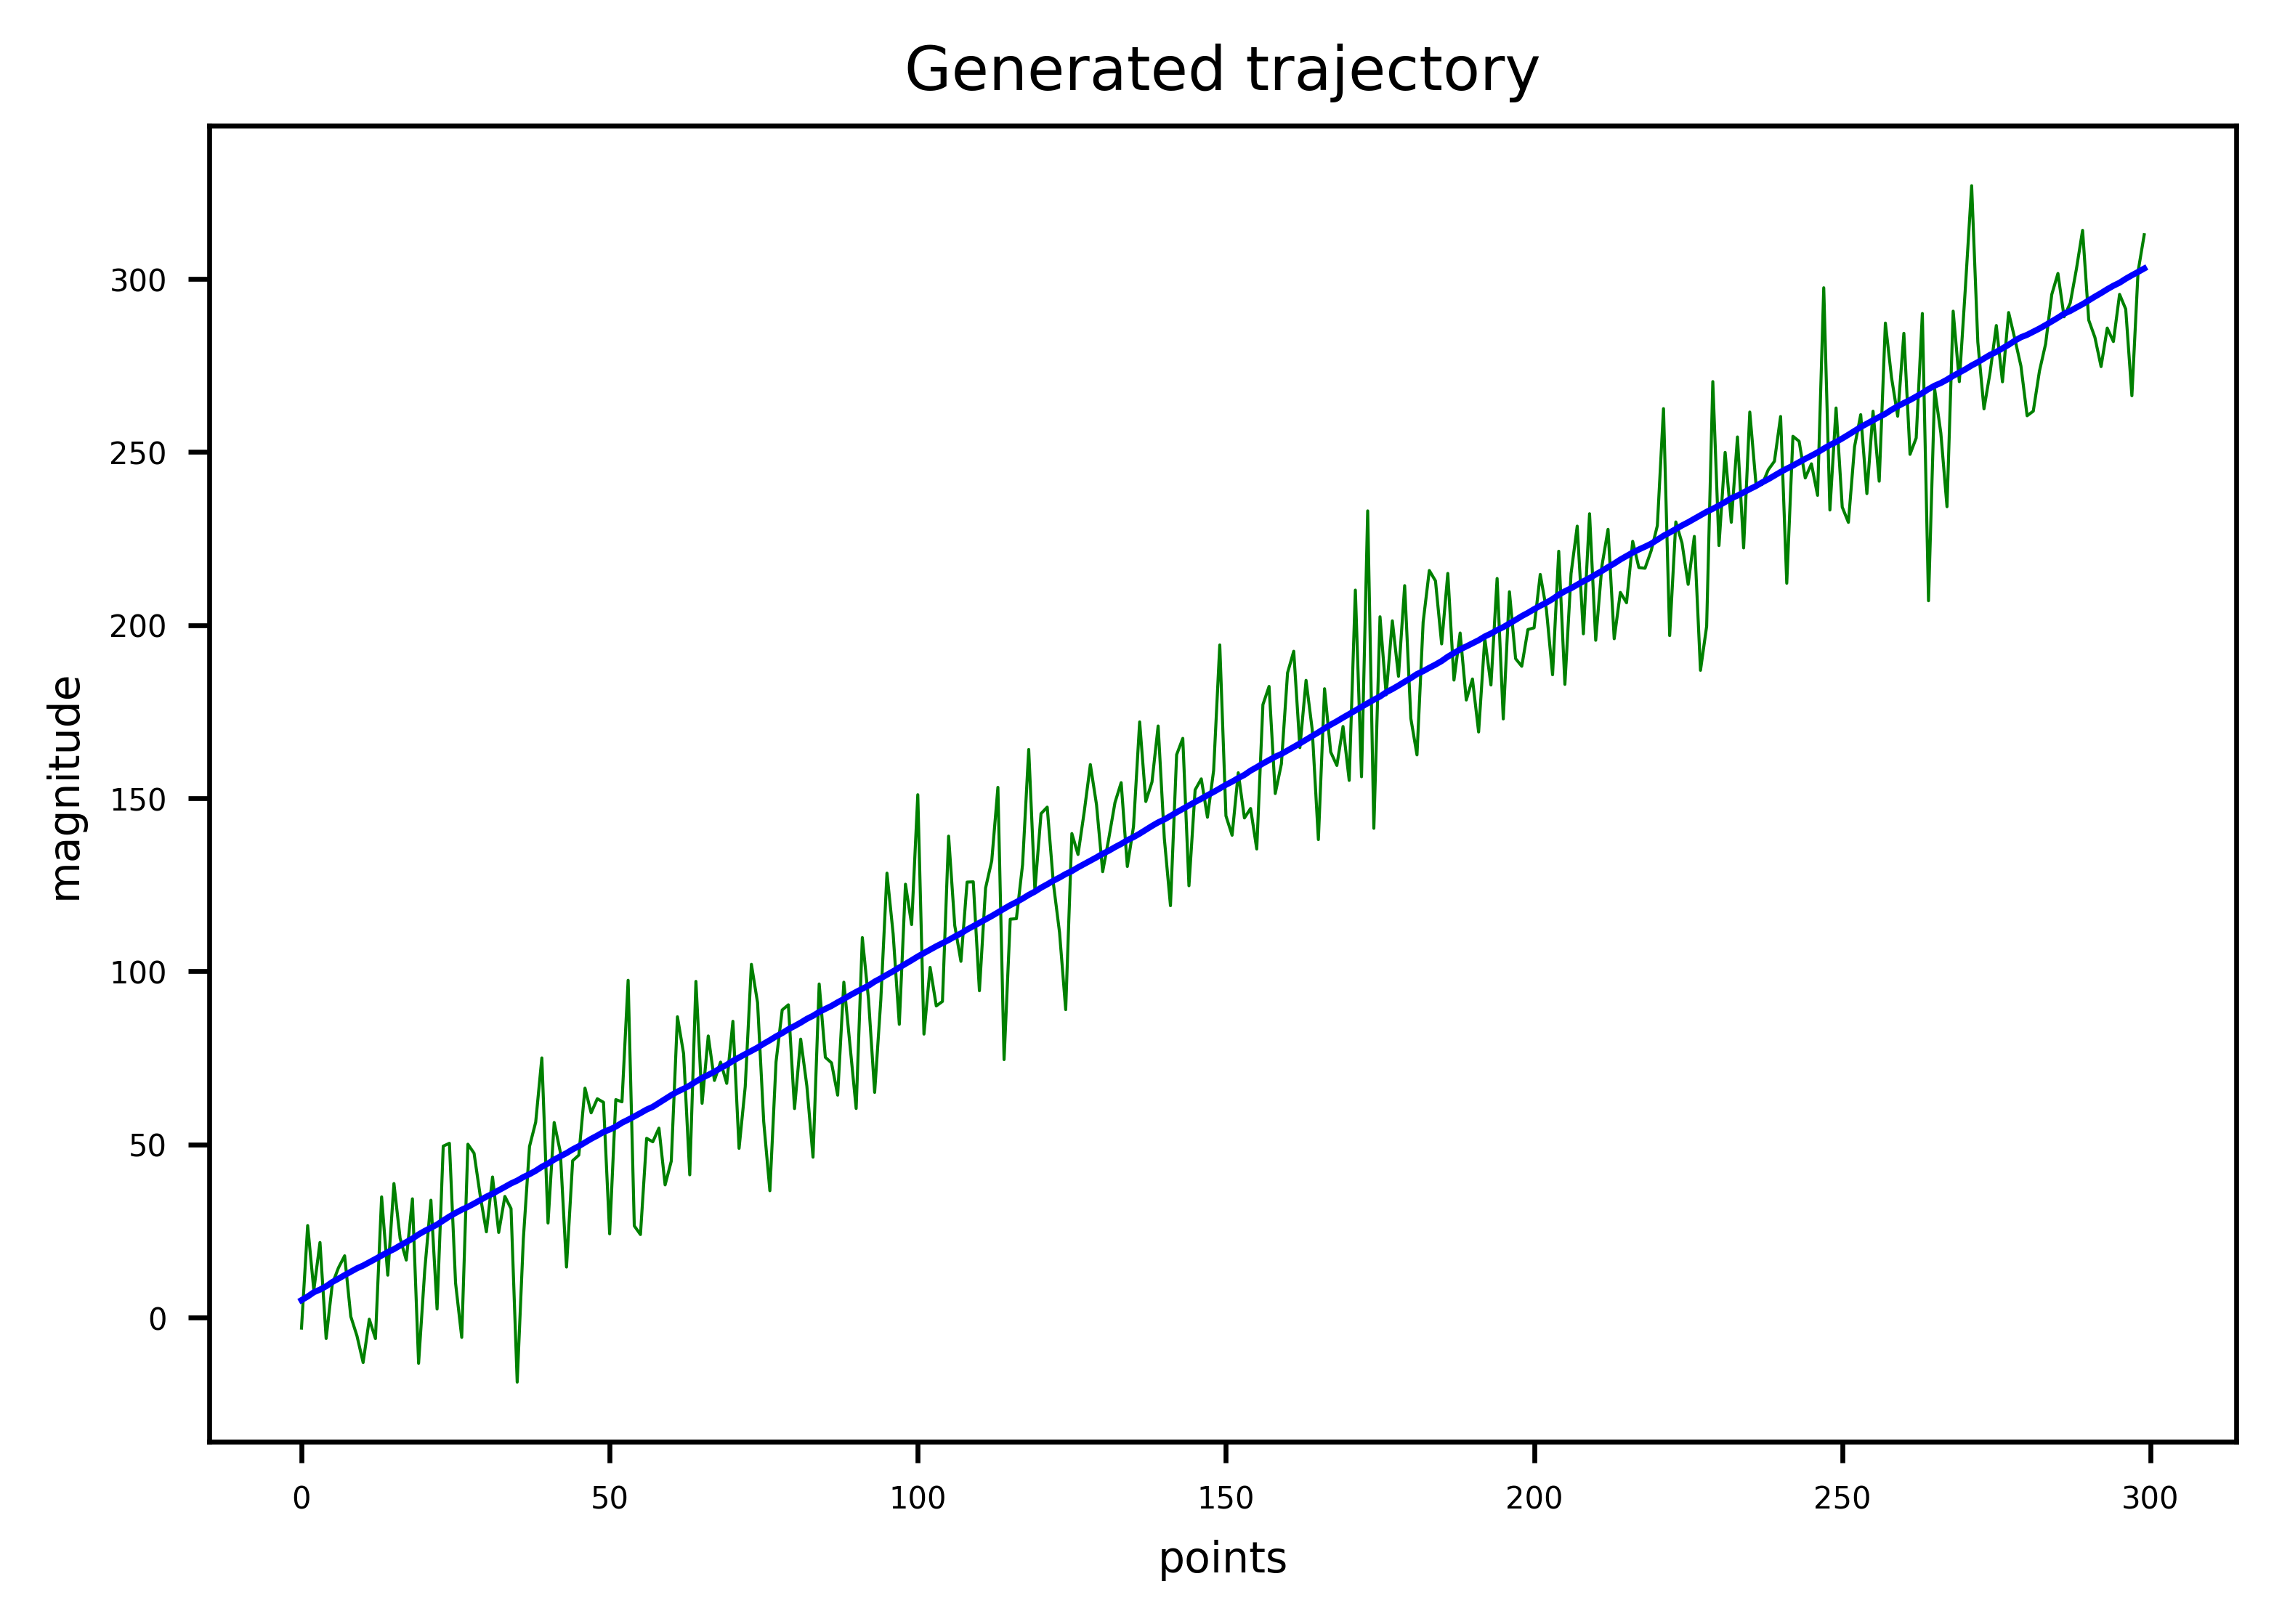

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi = 600)
ax.set_title('Generated trajectory', fontsize = 10)
ax.plot(range(N),z,'g', label = 'z', linewidth = 0.5 )
ax.plot(range(N),x,'b', label = 'x', linewidth = 1 )
#ax.plot(range(N),X[:,0].transpose()[0],'r', label = 'X', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax.set_xlabel('points', fontsize = 7)
ax.set_ylabel('magnitude', fontsize = 7);

In [10]:
np.sum((X[:,0].transpose()[0]-z)**2)
X[:,0].transpose()[0][0]

-16.106649980916487

In [72]:
np.identity(2).dot(np.array([[1],[0]]))

array([[ 1.],
       [ 0.]])

In [18]:
print(np.array([[1], [2]]))
print(np.array([[1, 2]]))

[[1]
 [2]]
[[1 2]]


In [16]:
x = np.ones((200, 2, 1))
print(x.shape)
x[1].shape

(200, 2, 1)


(2, 1)